In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd  drive/MyDrive/Colab Notebooks/artifical_assignment/Deepfake Asnmnt/

/content/drive/MyDrive/Colab Notebooks/artifical_assignment/Deepfake Asnmnt


In [3]:
!pip install timm
import timm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.4 MB/s eta 0:00:00


In [4]:
import torchvision.datasets as dsets
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [5]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, file_names, transform=None):
        self.folder_path = folder_path
        self.file_names = file_names
        self.transform = transform
        
    def __getitem__(self, index):
        file_name = self.file_names[index]
        class_name = file_name.split('_')[0]
        if class_name == 'fake':
          class_name = 1
        else:
          class_name = 0
          
        image_path = os.path.join(self.folder_path, file_name)       
        image = Image.open(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, class_name
    
    def __len__(self):
        return len(self.file_names)

In [6]:
def make_testdata(folder_path, transform):
  if folder_path == 'video/video_1':
    image_path = os.path.join(folder_path, "face_0.png")
    image = Image.open(image_path)
    input_tensor_0 = transform(image)
    input_batch_0 = input_tensor_0.unsqueeze(0)
    image_path = os.path.join(folder_path, "face_1.png")
    image = Image.open(image_path)
    input_tensor_1 = transform(image)
    input_batch_1 = input_tensor_1.unsqueeze(0)
    combined_tensor = torch.cat((input_batch_0, input_batch_1), dim=0)

  else:   
    image_path = os.path.join(folder_path, "face_0.png")
    image = Image.open(image_path)
    input_tensor_0 = transform(image)
    input_batch_0 = input_tensor_0.unsqueeze(0)
    image_path = os.path.join(folder_path, "face_1.png")
    image = Image.open(image_path)
    input_tensor_1 = transform(image)
    input_batch_1 = input_tensor_1.unsqueeze(0)
    image_path = os.path.join(folder_path, "face_2.png")
    image = Image.open(image_path)
    input_tensor_2 = transform(image)
    input_batch_2 = input_tensor_2.unsqueeze(0)
    image_path = os.path.join(folder_path, "face_3.png")
    image = Image.open(image_path)
    input_tensor_3 = transform(image)
    input_batch_3 = input_tensor_3.unsqueeze(0)
    combined_tensor = torch.cat((input_batch_0, input_batch_1, input_batch_2, input_batch_3), dim=0)

  return combined_tensor

In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
folder_path = 'High Quality/f2f_data/train'
file_names = os.listdir(folder_path)
HQ_F2F_train = CustomDataset(folder_path, file_names, transform=transform)
HQ_F2F_train_loader = torch.utils.data.DataLoader(dataset=HQ_F2F_train, batch_size=64, shuffle=True, drop_last=True)

folder_path = 'High Quality/f2f_data/val'
file_names = os.listdir(folder_path)
HQ_F2F_val = CustomDataset(folder_path, file_names, transform=transform)
HQ_F2F_val_loader = torch.utils.data.DataLoader(dataset=HQ_F2F_val, batch_size=64, shuffle=True, drop_last=True)

In [9]:
folder_path = 'High Quality/nt_data/train'
file_names = os.listdir(folder_path)
HQ_NT_train = CustomDataset(folder_path, file_names, transform=transform)
HQ_NT_train_loader = torch.utils.data.DataLoader(dataset=HQ_NT_train, batch_size=64, shuffle=True, drop_last=True)

folder_path = 'High Quality/nt_data/val'
file_names = os.listdir(folder_path)
HQ_NT_val = CustomDataset(folder_path, file_names, transform=transform)
HQ_NT_val_loader = torch.utils.data.DataLoader(dataset=HQ_NT_val, batch_size=64, shuffle=True, drop_last=True)

In [10]:
folder_path = 'Low Quality/f2f_data/train'
file_names = os.listdir(folder_path)
LQ_F2F_train = CustomDataset(folder_path, file_names, transform=transform)
LQ_F2F_train_loader = torch.utils.data.DataLoader(dataset=LQ_F2F_train, batch_size=64, shuffle=True, drop_last=True)

folder_path = 'Low Quality/f2f_data/val'
file_names = os.listdir(folder_path)
LQ_F2F_val = CustomDataset(folder_path, file_names, transform=transform)
LQ_F2F_val_loader = torch.utils.data.DataLoader(dataset=LQ_F2F_val, batch_size=64, shuffle=True, drop_last=True)

In [11]:
folder_path = 'Low Quality/nt_data/train'
file_names = os.listdir(folder_path)
LQ_NT_train = CustomDataset(folder_path, file_names, transform=transform)
LQ_NT_train_loader = torch.utils.data.DataLoader(dataset=LQ_NT_train, batch_size=64, shuffle=True, drop_last=True)

folder_path = 'Low Quality/nt_data/val'
file_names = os.listdir(folder_path)
LQ_NT_val = CustomDataset(folder_path, file_names, transform=transform)
LQ_NT_val_loader = torch.utils.data.DataLoader(dataset=LQ_NT_val, batch_size=64, shuffle=True, drop_last=True)

In [12]:
HQ_train_dataset = ConcatDataset([HQ_F2F_train_loader.dataset, HQ_NT_train_loader.dataset])
HQ_train_loader = torch.utils.data.DataLoader(dataset=HQ_train_dataset, batch_size=64, shuffle=True, drop_last=True)

HQ_val_dataset = ConcatDataset([HQ_F2F_val_loader.dataset, HQ_NT_val_loader.dataset])
HQ_val_loader = torch.utils.data.DataLoader(dataset=HQ_val_dataset, batch_size=64, shuffle=True, drop_last=True)

In [13]:
LQ_train_dataset = ConcatDataset([LQ_F2F_train_loader.dataset, LQ_NT_train_loader.dataset])
LQ_train_loader = torch.utils.data.DataLoader(dataset=LQ_train_dataset, batch_size=64, shuffle=True, drop_last=True)

LQ_val_dataset = ConcatDataset([LQ_F2F_val_loader.dataset, LQ_NT_val_loader.dataset])
LQ_val_loader = torch.utils.data.DataLoader(dataset=LQ_val_dataset, batch_size=64, shuffle=True, drop_last=True)

In [14]:
image_folder = ["video/video_1", "video/video_2", "video/video_3", "video/video_4", "video/video_5", "video/video_6", "video/video_7", "video/video_8", "video/video_9", "video/video_10", 
                "video/video_11", "video/video_12", "video/video_13", "video/video_14", "video/video_15", "video/video_16", "video/video_17", "video/video_18", "video/video_19"]

In [15]:
test_images = make_testdata("video/video_0", transform)

for i in image_folder:
  temp_images = make_testdata(i, transform)
  test_images = torch.cat((test_images, temp_images), dim=0)

In [16]:
test_images.shape

torch.Size([78, 3, 224, 224])

In [17]:
def train_valid(model, train_data_loader, val_data_loader):
  num_epochs = 100
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
  loss_func = torch.nn.BCELoss()

  for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(train_data_loader):
      data, target = data.to(device), target.to(device)
      target_onehot = torch.eye(2).to(device)[target]

      output = torch.sigmoid(model(data))  
      loss = loss_func(output, target_onehot)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      train_loss += loss.item()
      _, predicted_train = torch.max(output.data, 1)
      total_train += target.size(0)
      correct_train += (predicted_train == target).sum().item()
    
    train_losses.append(train_loss / len(train_data_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(train_data_loader):
        data, target = data.to(device), target.to(device)
        target_onehot = torch.eye(2).to(device)[target]

        output = torch.sigmoid(model(data))  
        loss = loss_func(output, target_onehot)
            
        val_loss += loss.item()
        _, predicted_val = torch.max(output.data, 1)
        total_val += target.size(0)
        correct_val += (predicted_val == target).sum().item()
    
    val_losses.append(val_loss / len(val_data_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Val Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


#HQ vs LQ

In [ ]:
model_HQ = timm.create_model('legacy_xception',num_classes=2, pretrained=True).to(device)
model_LQ = timm.create_model('legacy_xception',num_classes=2, pretrained=True).to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch [1/100], Train Loss: 25.5054, Train Acc: 0.5629, Val Loss: 25.9503, Val Acc: 0.6212
Epoch [2/100], Train Loss: 24.9715, Train Acc: 0.6005, Val Loss: 190.1373, Val Acc: 0.5891
Epoch [3/100], Train Loss: 22.4016, Train Acc: 0.7095, Val Loss: 26.3300, Val Acc: 0.7019
Epoch [4/100], Train Loss: 18.5582, Train Acc: 0.8019, Val Loss: 67.3431, Val Acc: 0.6575
Epoch [5/100], Train Loss: 16.2931, Train Acc: 0.8421, Val Loss: 14.3898, Val Acc: 0.8720
Epoch [6/100], Train Loss: 11.5004, Train Acc: 0.8889, Val Loss: 15.7718, Val Acc: 0.8328
Epoch [7/100], Train Loss: 8.8533, Train Acc: 0.9024, Val Loss: 47.7857, Val Acc: 0.6706
Epoch [8/100], Train Loss: 5.7469, Train Acc: 0.9459, Val Loss: 3.5542, Val Acc: 0.9671
Epoch [9/100], Train Loss: 4.1672, Train Acc: 0.9561, Val Loss: 10.3304, Val Acc: 0.8965
Epoch [10/100], Train Loss: 2.4295, Train Acc: 0.9785, Val Loss: 26.4531, Val Acc: 0.8476
Epoch [11/100], Train Loss: 2.9847, Train Acc: 0.9713, Val Loss: 4.9659, Val Acc: 0.9595
Epoch [12/100]

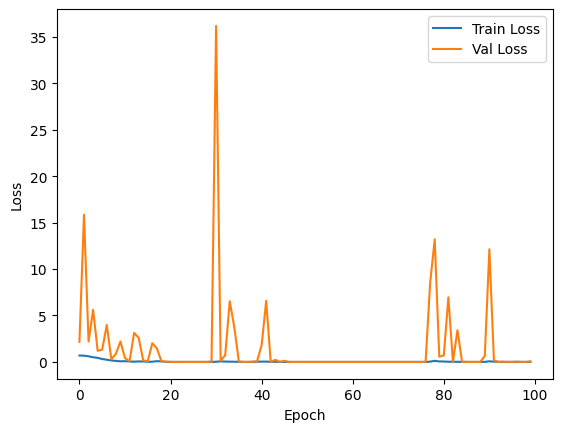

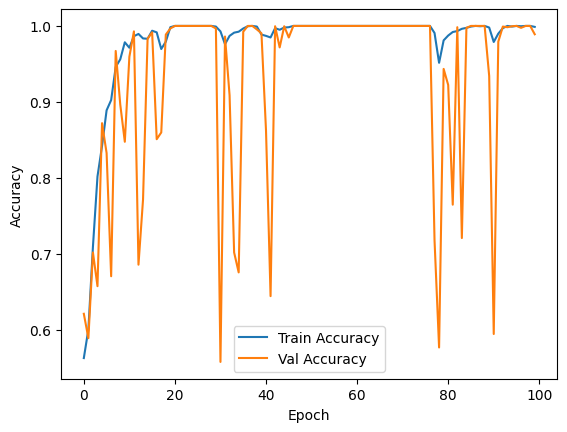

In [ ]:
train_valid(model_HQ, HQ_train_loader, HQ_val_loader)

In [ ]:
predict_HQ = torch.sigmoid(model_HQ(test_images.to(device)))

In [ ]:
result_HQ = torch.round(predict_HQ * 100) / 100
for i, row in enumerate(result_HQ):
  rounded_value = round(row[1].item(), 2)
  print(f"{i+1}: {rounded_value}")

1: 0.1
2: 0.0
3: 0.0
4: 0.99
5: 1.0
6: 0.97
7: 0.13
8: 0.97
9: 0.01
10: 0.53
11: 0.0
12: 0.0
13: 0.0
14: 1.0
15: 0.0
16: 0.0
17: 0.31
18: 0.87
19: 0.0
20: 0.0
21: 0.0
22: 0.0
23: 0.0
24: 0.0
25: 0.0
26: 0.0
27: 0.0
28: 0.0
29: 0.01
30: 0.19
31: 0.95
32: 0.0
33: 1.0
34: 1.0
35: 0.0
36: 0.0
37: 0.22
38: 0.0
39: 0.0
40: 0.0
41: 0.0
42: 0.0
43: 0.11
44: 0.0
45: 1.0
46: 0.0
47: 0.0
48: 0.0
49: 1.0
50: 0.0
51: 0.0
52: 0.0
53: 0.0
54: 0.0
55: 0.0
56: 0.0
57: 0.42
58: 1.0
59: 0.76
60: 0.0
61: 1.0
62: 1.0
63: 0.04
64: 0.0
65: 0.0
66: 0.0
67: 0.04
68: 0.99
69: 0.08
70: 1.0
71: 0.61
72: 1.0
73: 0.81
74: 0.0
75: 0.0
76: 0.91
77: 0.96
78: 0.68


Epoch [1/100], Train Loss: 14.7200, Train Acc: 0.8450, Val Loss: 34.4278, Val Acc: 0.4797
Epoch [2/100], Train Loss: 4.4134, Train Acc: 0.9561, Val Loss: 57.5133, Val Acc: 0.7344
Epoch [3/100], Train Loss: 1.7488, Train Acc: 0.9831, Val Loss: 225.3303, Val Acc: 0.6064
Epoch [4/100], Train Loss: 1.8058, Train Acc: 0.9835, Val Loss: 102.5403, Val Acc: 0.5287
Epoch [5/100], Train Loss: 2.9034, Train Acc: 0.9738, Val Loss: 153.4417, Val Acc: 0.5355
Epoch [6/100], Train Loss: 0.7654, Train Acc: 0.9945, Val Loss: 1.8078, Val Acc: 0.9802
Epoch [7/100], Train Loss: 0.2934, Train Acc: 0.9979, Val Loss: 0.2823, Val Acc: 0.9987
Epoch [8/100], Train Loss: 0.1182, Train Acc: 0.9992, Val Loss: 1.5872, Val Acc: 0.9907
Epoch [9/100], Train Loss: 0.7657, Train Acc: 0.9932, Val Loss: 2.6423, Val Acc: 0.9797
Epoch [10/100], Train Loss: 0.2166, Train Acc: 0.9983, Val Loss: 0.0836, Val Acc: 0.9992
Epoch [11/100], Train Loss: 0.1924, Train Acc: 0.9987, Val Loss: 0.0637, Val Acc: 1.0000
Epoch [12/100], Train

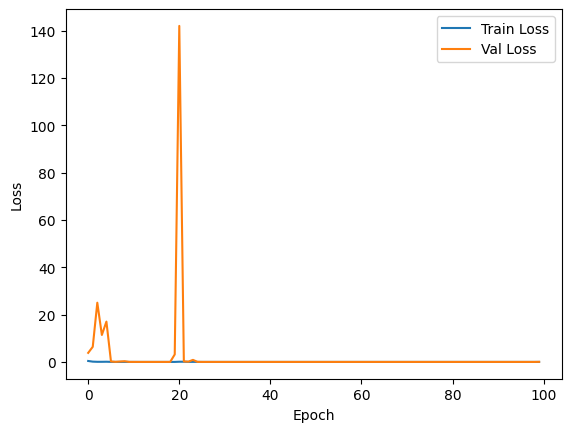

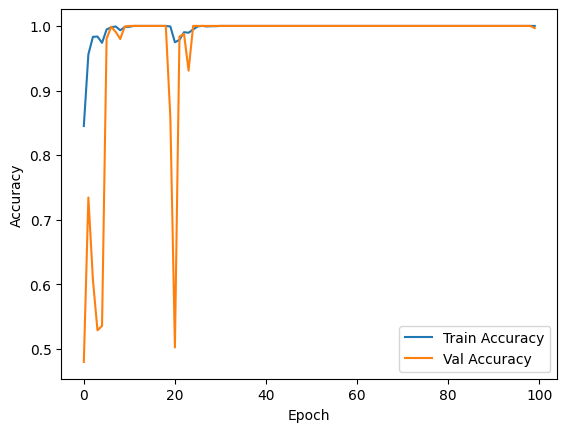

In [ ]:
train_valid(model_LQ, LQ_train_loader, LQ_val_loader)

In [ ]:
predict_LQ = torch.sigmoid(model_LQ(test_images.to(device)))

In [ ]:
result_LQ = torch.round(predict_LQ * 100) / 100
for i, row in enumerate(result_LQ):
  rounded_value = round(row[1].item(), 2)
  print(f"{i+1}: {rounded_value}")

1: 0.72
2: 0.0
3: 1.0
4: 0.39
5: 0.99
6: 0.0
7: 0.09
8: 1.0
9: 0.74
10: 1.0
11: 0.0
12: 0.6
13: 1.0
14: 0.0
15: 1.0
16: 0.01
17: 0.0
18: 0.0
19: 0.0
20: 0.0
21: 0.0
22: 0.0
23: 0.0
24: 0.0
25: 0.01
26: 0.0
27: 1.0
28: 1.0
29: 0.0
30: 0.0
31: 0.0
32: 0.0
33: 0.0
34: 0.0
35: 0.54
36: 1.0
37: 1.0
38: 1.0
39: 0.65
40: 0.99
41: 0.04
42: 0.03
43: 0.0
44: 0.99
45: 0.0
46: 1.0
47: 0.0
48: 0.0
49: 1.0
50: 0.0
51: 0.72
52: 0.95
53: 0.92
54: 0.0
55: 0.0
56: 0.0
57: 0.01
58: 0.79
59: 0.0
60: 0.0
61: 0.0
62: 0.0
63: 0.0
64: 0.0
65: 0.0
66: 0.0
67: 0.01
68: 0.0
69: 0.03
70: 0.0
71: 0.0
72: 0.0
73: 0.16
74: 0.0
75: 0.79
76: 0.65
77: 0.0
78: 0.0


#Ensemble models

In [18]:
model_xception = timm.create_model('legacy_xception',num_classes=2, pretrained=True).to(device)
model_efficient = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch [1/100], Train Loss: 25.5097, Train Acc: 0.5059, Val Loss: 1569.3567, Val Acc: 0.5051
Epoch [2/100], Train Loss: 24.6290, Train Acc: 0.6106, Val Loss: 38.8339, Val Acc: 0.6178
Epoch [3/100], Train Loss: 22.5647, Train Acc: 0.6854, Val Loss: 160.9892, Val Acc: 0.5650
Epoch [4/100], Train Loss: 19.6775, Train Acc: 0.7745, Val Loss: 23.7748, Val Acc: 0.8062
Epoch [5/100], Train Loss: 12.8909, Train Acc: 0.8623, Val Loss: 26.8167, Val Acc: 0.7990
Epoch [6/100], Train Loss: 8.0351, Train Acc: 0.9202, Val Loss: 151.2611, Val Acc: 0.6444
Epoch [7/100], Train Loss: 4.5978, Train Acc: 0.9459, Val Loss: 9.9391, Val Acc: 0.9126
Epoch [8/100], Train Loss: 3.8587, Train Acc: 0.9658, Val Loss: 25.8955, Val Acc: 0.8226
Epoch [9/100], Train Loss: 2.6035, Train Acc: 0.9734, Val Loss: 2.8074, Val Acc: 0.9666
Epoch [10/100], Train Loss: 1.8210, Train Acc: 0.9827, Val Loss: 23.9169, Val Acc: 0.8247
Epoch [11/100], Train Loss: 0.9200, Train Acc: 0.9916, Val Loss: 1.2762, Val Acc: 0.9865
Epoch [12/100

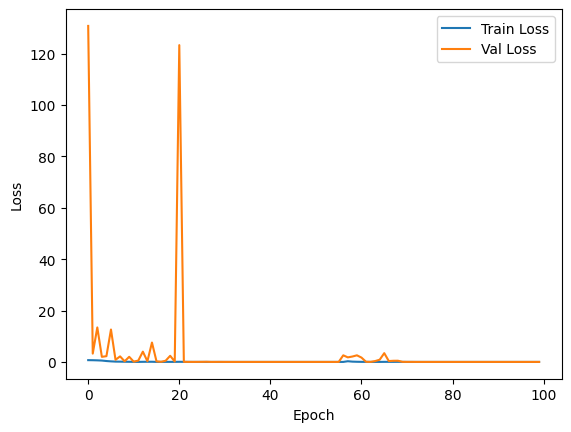

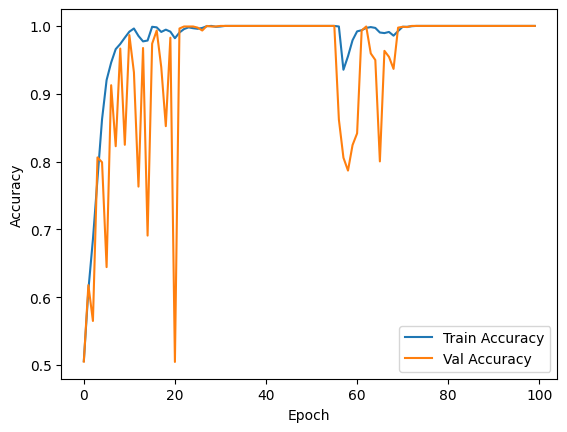

In [19]:
train_valid(model_xception, HQ_train_loader, HQ_val_loader)

In [20]:
predict_xception = torch.sigmoid(model_xception(test_images.to(device)))

Epoch [1/100], Train Loss: 172.7078, Train Acc: 0.5367, Val Loss: 78.1177, Val Acc: 0.5908
Epoch [2/100], Train Loss: 61.9150, Train Acc: 0.5950, Val Loss: 377.9845, Val Acc: 0.5232
Epoch [3/100], Train Loss: 64.9932, Train Acc: 0.5300, Val Loss: 105.3986, Val Acc: 0.5912
Epoch [4/100], Train Loss: 56.6211, Train Acc: 0.5823, Val Loss: 55.3967, Val Acc: 0.6250
Epoch [5/100], Train Loss: 54.4256, Train Acc: 0.6385, Val Loss: 52.9828, Val Acc: 0.6892
Epoch [6/100], Train Loss: 58.8482, Train Acc: 0.6748, Val Loss: 45.5745, Val Acc: 0.7213
Epoch [7/100], Train Loss: 50.6228, Train Acc: 0.7171, Val Loss: 21.7508, Val Acc: 0.6799
Epoch [8/100], Train Loss: 42.4672, Train Acc: 0.6731, Val Loss: 44.7159, Val Acc: 0.5528
Epoch [9/100], Train Loss: 37.0902, Train Acc: 0.6778, Val Loss: 27.5197, Val Acc: 0.7023
Epoch [10/100], Train Loss: 27.8381, Train Acc: 0.7340, Val Loss: 84.3184, Val Acc: 0.7872
Epoch [11/100], Train Loss: 17.1073, Train Acc: 0.7893, Val Loss: 38.2494, Val Acc: 0.7910
Epoch

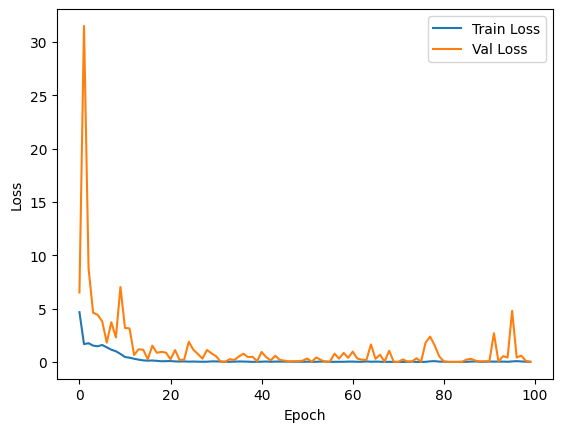

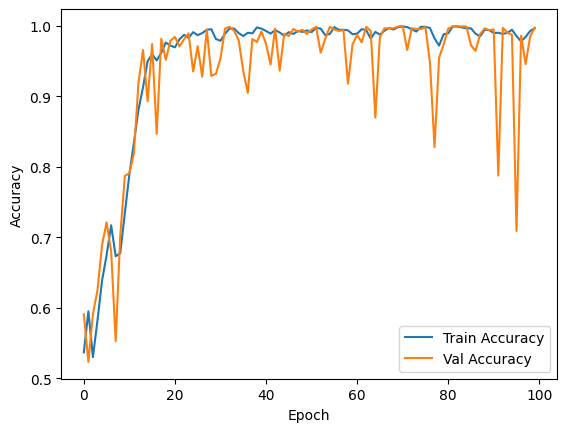

In [21]:
train_valid(model_efficient, HQ_train_loader, HQ_val_loader)

In [22]:
predict_efficient = torch.sigmoid(model_efficient(test_images.to(device)))

In [23]:
ensemble_prediction = (predict_xception + predict_efficient) / 2

In [24]:
result_ensemble = torch.round(ensemble_prediction * 100) / 100
for i, row in enumerate(result_ensemble):
  rounded_value = round(row[1].item(), 2)
  print(f"{i+1}: {rounded_value}")

1: 0.5
2: 0.49
3: 0.5
4: 0.4
5: 0.65
6: 0.5
7: 0.5
8: 0.72
9: 0.97
10: 0.98
11: 0.5
12: 0.49
13: 0.49
14: 0.5
15: 0.5
16: 0.5
17: 0.5
18: 0.5
19: 0.01
20: 0.0
21: 0.35
22: 0.0
23: 0.0
24: 0.0
25: 0.5
26: 0.5
27: 0.5
28: 0.5
29: 0.5
30: 0.06
31: 0.5
32: 0.5
33: 0.5
34: 0.54
35: 0.04
36: 0.21
37: 0.5
38: 0.5
39: 0.49
40: 0.46
41: 0.0
42: 0.0
43: 0.49
44: 0.5
45: 0.0
46: 0.3
47: 0.0
48: 0.02
49: 0.51
50: 0.3
51: 0.0
52: 0.0
53: 0.5
54: 0.49
55: 0.0
56: 0.0
57: 0.5
58: 0.91
59: 0.01
60: 0.0
61: 0.0
62: 0.7
63: 0.01
64: 0.07
65: 0.0
66: 0.5
67: 0.41
68: 0.5
69: 0.5
70: 0.5
71: 1.0
72: 0.14
73: 0.86
74: 0.5
75: 0.99
76: 0.56
77: 0.58
78: 0.47
